In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from pathlib import Path
from tensorflow.keras import layers
from tensorflow import feature_column
from matplotlib import pyplot as plt
# Serves to check that the Tensor Flow version is correct and imported correctly
print('tensorflow version', tf.__version__)
print('pandas', pd.__version__)

In [ ]:
# Read in data and create a dataframe.
# Create a columns array
columns = ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean']
columns_float = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean']
# Later we will need to split the data set into validation, test and training
df = pd.read_csv('BreastCancerDataMeans.csv', names=columns, index_col=False)
# Drop the ID column which we do not need, as well as the redundant headings
df = df.drop('id', 1)
df = df.drop(0)
# Need to convert the object values into floats and the diagnosis into a string
df['diagnosis'] = df.apply(lambda x: np.array(x['diagnosis']).astype(str), axis=1)
for i in range(len(columns_float)):
    df[columns_float[i]] = df.apply(lambda x: np.array(x[columns_float[i]]).astype(float), axis=1)
# Need to convert the Malignant or Bengin result into a binary value
df['diagnosis'] = df['diagnosis'].map({'M': 0, 'B':1})

In [ ]:
# Split the data. Use a 75% training and 25% test split
# test_size is how much of the data will be used for testing
# random_state controls the shuffling to tae place, by defining the random state we can reproduce the same split of the data across multiple function calls
# shuffle, we will enable this as the data may be organised in a certain way which could affect our results
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42, shuffle=True)
# Define path for test and training data to be saved and convert them to CSV
train_path = Path('train.tsv')
test_path = Path('test.tsv')
train_df.to_csv(train_path, sep='\t', index=False)
test_df.to_csv(test_path, sep='\t', index=False)

In [ ]:
# Normalize the data over all the values, besides for target value
# Calculate the z score
# All rows, columns between 1 and 5
#Normalising
train_df_norm = train_df.iloc[:,1:5].sub(train_df_mean, axis=1)
train_df_norm = train_df_norm.div(train_df_std, axis=1)

#reassigning to dataframe
#if rerunning, need to reimport data. the drop function permenantly changes dataframe meaning it can only operate once
train_df_temp = train_df
train_df_temp = train_df_temp.drop(columns = ["radius_mean",  "texture_mean",  "perimeter_mean",  "area_mean"]) #colums 1,2,3,4
train_df = pd.concat([train_df_temp, train_df_norm], axis = 1)
print(train_df)

In [ ]:
test_df_norm = test_df.iloc[:,1:5].sub(test_df_mean, axis=1)
test_df_norm = test_df_norm.div(test_df_std, axis=1)

#reassigning to dataframe
#if rerunning, need to reimport data. the drop function permenantly changes dataframe meaning it can only operate once
test_df_temp = test_df
test_df_temp = test_df_temp.drop(columns = ["radius_mean",  "texture_mean",  "perimeter_mean",  "area_mean"])
test_df = pd.concat([test_df_temp, test_df_norm], axis = 1)


In [ ]:
# Loop through the paramaters and add them to the feature vecture which will be used to train the model
featureColumns = []
for i in columns_float:
    featureColumns.append(tf.feature_column.numeric_column(i))
#featureColumns.append(tf.feature_column.numeric_column('radius_mean'))
#featureColumns.append(tf.feature_column.numeric_column('texture_mean'))
featureLayer = tf.keras.layers.DenseFeatures(featureColumns)

In [ ]:
# Define the model topography, creating a simple classification model
def createModel(myLearningRate, featureLayer, myMetrics):
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
    # Add the list of features and how they are represented
    model.add(featureLayer)
    # Use a sigmoid activation function to funnel
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation=tf.sigmoid),)
    # Compile method will construct the layers into a model that TensorFlow can execute
    # RMSprop is used to maintain a moving average of the square of the gradients, then divide the gradient by the root of the average
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=myLearningRate), loss=tf.keras.losses.binary_crossentropy, metrics=myMetrics)
    return model

In [ ]:
# Feed in a dataset into the model to train it
# Epoch is a run through of the whole dataset, if we batch size then we only pass through parts of the dataset at a time
# Epoch and batchSize will be changed to reduce the error rate
def trainModel(model, dataset, epochs, labelName, batchSize = None, shuffle = True):
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(labelName))
    # x paramter can be an array of the data for each feature. Feature layer will be filtering out the columns we don't want
    history = model.fit(x=features, y=label, batch_size=batchSize, epochs=epochs, shuffle=shuffle)
    # Can see the output of the model being trained over time
    epochs = history.epoch
    # Isolate the classification metric for each epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [ ]:
# Define a plotting function in order to visualize the training of the model
def plotCurve(epochs, history, metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in metrics:
        x = history[m]
        plt.plot(epochs[1:], x[1:], label = m)
    plt.legend()

In [ ]:
# Plot the trained model against random training examples using MatPlotLib
def plotModel(trainedWeight, trainedBias, feature, label):
    plt.xlabel(feature)
    plt.ylabel(label)
    randomExamples = training_df.sample(n=200)
    plt.scatter(randomExamples[feature], randomExamples[label])

    x0 = 0
    y0 = trainedBias
    x1 = 10000
    y1 = trainedBias + (trainedWeight * x1)
    plt.plot([x0, x1], [y0, y1], c="r")
    plt.show()

In [ ]:
# Define and plot the loss curve, which will show how the model performs over epochs
def plotLossCurve(epochs, rmse):
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.97, rmse.max()])
    plt.show()

Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
43/43 [==============================] - 0s 3ms/step - loss: 21.3397 - accuracy: 0.4953 - precision: 0.5718 - recall: 0.7873
Epoch 2/100
43/43 [==============================] - 0s 3ms/step - loss: 13.3237 - accuracy: 0.1972 - precision: 0.3112 - recall: 0.2276
Epoch 3/100
43/43 [==============================] - 0s 3ms/step - loss: 12.2860 - accuracy: 0.1362 - precision: 0.0902 - recall: 0.0410
Epoch 4/100
43/43 [==============================] - 0s 5ms/step - loss: 11.6949 - accuracy: 0.1268 - precision: 0.0873 - recall: 0.0410
Epoch 5/100
43/43 [==============================] - 0s 3ms/step - loss: 11.1618 - accuracy: 0.1432 - precision: 0.1057 - recall: 0.0485
Epoch 6/100
43/43 [==============================] - 0s 3ms/step - loss: 10.6108 - accuracy: 0.1197 - precision: 0.0787 - recall: 0.0373
Epoch 7/100
43/43 [==============================] - 0s 2ms/step - l

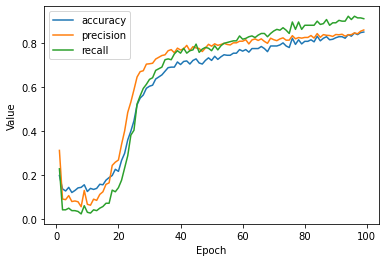

In [25]:
# Invoke the functions
# Accuracy, how well predicts the label
# Precision, divides true positives by false positives
# Recall, divides true positives by sum of true positives and false positives
learningRate = 0.001
epochs = 100
batchSize = 10
labelName = "diagnosis"
classificationThreshold = 0.5

metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classificationThreshold), tf.keras.metrics.Precision(thresholds = classificationThreshold, name = 'precision'), tf.keras.metrics.Recall(thresholds = classificationThreshold,
                              name =  'recall')]
myModel = createModel(learningRate, featureLayer, metrics)
epochs, hist = trainModel(myModel, train_df, epochs, 
                           labelName, batchSize)
metricsToPlot = ['accuracy', 'precision', 'recall']
plotCurve(epochs, hist, metricsToPlot)